# Cats and Dogs image classification
[Flask app example](https://github.com/amitrajitbose/cat-v-dog-classifier-pytorch)

# 0. Getting the data
The dataset can be downloaded from the [offical Kaggle competition page](https://www.kaggle.com/c/dogs-vs-cats/data). Once you have downloaded and extracted the data, the file structure should look like this:

```
dogs-vs-cats
-- train
---- cat.1.jpg
---- dog.1.jpg
---- ...
-- test
---- 1.jpg
---- 2.jpg
---- ...
```

### Create seperate cat and dog folders
The test set has no labels, so we will leave that as is. However, we want to group all cat and dog images into seperate folders within `train` to fit with format expected by the `torchvision.datasets.ImageFolder` class.

Within the downloaded data folder, add the following new folders:
  - train/cat
  - train/dog
  - val/cat
  - val/dog

In [1]:
import os, re, shutil
from tqdm.notebook import tqdm

data_dir = './dogs-vs-cats'
train_dir = data_dir+'/train'
train_dogs_dir = train_dir + '/dog'
train_cats_dir = train_dir + '/cat'
val_dir = data_dir+'/val'
val_dogs_dir = val_dir + '/dog'
val_cats_dir = val_dir + '/cat'

for im_dir in [train_dogs_dir, train_cats_dir, val_dir, val_dogs_dir, val_cats_dir]:
    if not os.path.exists(im_dir):
        os.makedirs(im_dir)

Your folder should now be structured as follows:

```
dogs-vs-cats
-- train
---- cat
------ cat.1.jpg
----dog
---- dog.1.jpg
-- val
---- cat
----dog
-- test
---- 1.jpg
---- 2.jpg
---- ...
```

### Move images into folders

In [2]:
files = os.listdir(train_dir)

# move all train cat images to cats folder, dog images to dogs folder
for f in tqdm(files):
    if 'cat' in f and '.jpg' in f:
        shutil.move(f'{train_dir}/{f}', train_cats_dir)
    elif 'dog' in f and '.jpg' in f:
        shutil.move(f'{train_dir}/{f}', train_dogs_dir)

Finally, move some images into the validation folder:

In [3]:
files = os.listdir(train_dogs_dir)
for f in tqdm(files):
    if re.search("5\d\d\d", f):
        shutil.move(f'{train_dogs_dir}/{f}', val_dogs_dir)
        
files = os.listdir(train_cats_dir)
for f in tqdm(files):
    if re.search("5\d\d\d", f):
        shutil.move(f'{train_cats_dir}/{f}', val_cats_dir)

Alternatively, another version of this dataset has been made available by Microsoft and is available [here](https://www.microsoft.com/en-us/download/details.aspx?id=54765). The code below can be used to download and unzip the data into your current directory.
> Note: the code will need to be adapted to work with the slightly different file structure of this version

```python
import zipfile, os, shutil
from urllib.request import urlopen

# stable link for dataset
url = 'https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/'
filename = 'kagglecatsanddogs_3367a.zip'

# download zip file from link
print('downloading and saving dataset from Microsoft stable link...')
downloaded = urlopen(url + filename)
buf = downloaded.read()

# save file and extract contents
with open(filename, 'wb') as f:
    f.write(buf)
    
print('unzipping contents')
with zipfile.ZipFile(filename) as zip:
    zip.extractall('.')

# remove zip file from directory
print('deleting zip file')
os.remove('kagglecatsanddogs_3367a.zip')

# free up some memory
del downloaded, buf
```

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models

### Check if host machine has GPU available

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


## Load Images
#### Apply transforms
Most of the pretrained models require the input to be 224x224 images. Also, we'll need to match the normalization used when the models were trained. Each color channel was normalized separately, the means are [0.485, 0.456, 0.406] and the standard deviations are [0.229, 0.224, 0.225]. (see these same values used in an official PyTorch example [here](https://github.com/pytorch/examples/blob/42e5b996718797e45c46a25c55b031e6768f8440/imagenet/main.py#L89-L101))

In [35]:
data_dir = 'dogs-vs-cats'

# Just normalization for validation
train_transforms = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train = datasets.ImageFolder(data_dir+'/train', transform=train_transforms)
test = datasets.ImageFolder(data_dir+'/val', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train, batch_size=64, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(test, batch_size=128, shuffle=True, num_workers=4)

In [7]:
print(len(train), len(test))

23000 2000


In [8]:
train.classes

['cat', 'dog']

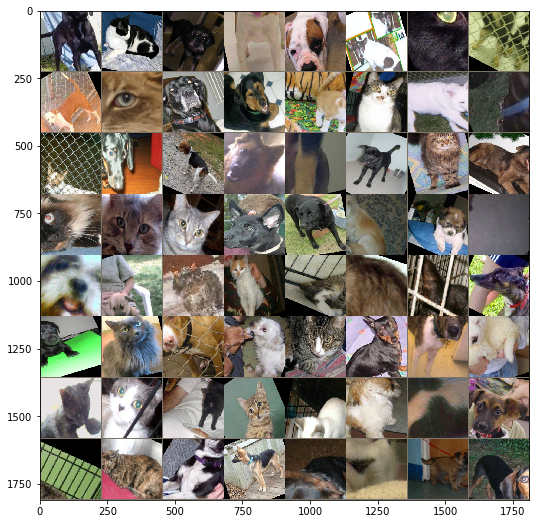

In [9]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = torchvision.utils.make_grid(inp)
    # in tensor, image is (batch, width, height)
    # so you have to transpose it to (width, height, batch) 
    # in numpy to show it.
    inp = inp.numpy().transpose((1, 2, 0))
    # de-normalise images to get original colours
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.figure(figsize=(9,9))
    plt.imshow(inp)

# Get a batch of training data
inputs, labels = next(iter(trainloader))
# show images in batch
imshow(inputs)

In [10]:
# load pre-trained densemodel model
model = torchvision.models.densenet121(pretrained=True)

# freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

### Replace the head of the model

In [11]:
# ensure the new head fits onto the existing body
num_ftrs = model.classifier.in_features
# define architecture of classifier head
classifier = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Linear(512,256),
    nn.ReLU(),
    nn.Linear(256, 2),
    nn.LogSoftmax(dim=-1)
)

# update the head on pretrained model
model.classifier = classifier

In [12]:
model = model.to(device)
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=.003)

In [14]:
epochs = 3
losses = []
for epoch in range(epochs):
    
    # turns on dropout
    model.train()
    
    batch = 1
    running_loss = 0.0
    for inputs, labels in tqdm(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        losses.append(running_loss / batch)
        batch += 1
    print(f'Epoch {epoch+1} training loss: {running_loss / batch:.3f}')
    
    # turn off gradients for validation, saves memory and computations
    with torch.no_grad():

        # turn off dropout
        model.eval()
        test_batch = 1
        val_loss = 0.0
        y_true = np.array([])
        y_pred = np.array([])
        for data in testloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).to('cpu')
            loss = criterion(outputs, labels.to('cpu'))
            val_loss += loss.item()

            _, batch_predictions = torch.max(outputs.data, 1)
            y_pred = np.hstack((y_pred, batch_predictions.numpy()))
            y_true = np.hstack((y_true, labels.to('cpu').numpy()))
            test_batch += 1

        print(f'Validation accuracy: {100*(y_true == y_pred).mean():.3f}%')

print('Finished Training')


Epoch 1 training loss: 0.156


RuntimeError: CUDA out of memory. Tried to allocate 686.00 MiB (GPU 0; 4.00 GiB total capacity; 1.52 GiB already allocated; 551.27 MiB free; 2.39 GiB reserved in total by PyTorch)

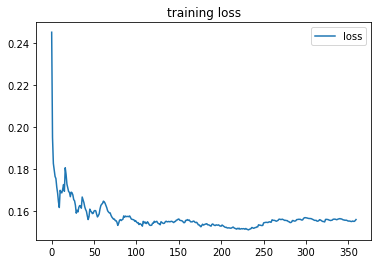

In [33]:
plt.plot(losses, label='loss')
plt.legend()
plt.title('training loss')
plt.show()

## Sample some test images and show predicted labels
**ToDo:**
  - use test images

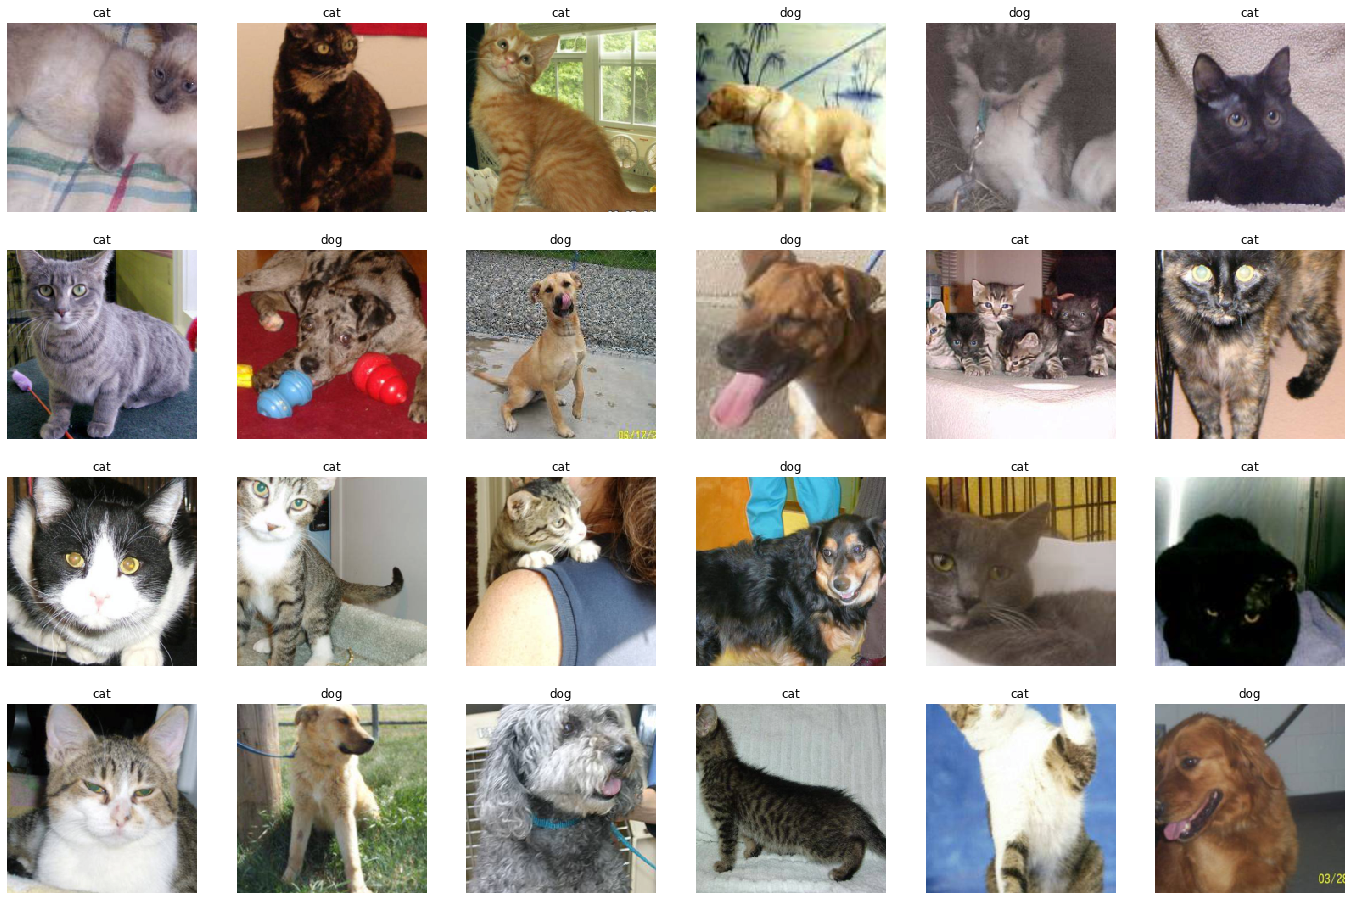

In [38]:
samples, _ = iter(testloader).next()  # ToDo: change to test images
samples = samples.to(device)
output = model(samples[:24])
pred = torch.argmax(output, dim=1)
pred = [p.item() for p in pred]
ad = {0:'cat', 1:'dog'}

fig = plt.figure(figsize=(24, 16))
fig.tight_layout()
for num, sample in enumerate(samples[:24]):
    plt.subplot(4,6,num+1)
    plt.title(ad[pred[num]])
    plt.axis('off')
    sample = sample.cpu().numpy()
    sample = np.transpose(sample, (1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    sample = std * sample + mean
    sample = np.clip(sample, 0, 1)
    plt.imshow(sample)